# Hybrid VAE-Transformer for Emotion-Aware Music Generation

This notebook implements a hybrid Variational Autoencoder (VAE) and Transformer model for generating emotion-aware music clips based on the EMOPIA and MAESTRO datasets.

## Project Overview
- **Dataset**: EMOPIA (emotion-labeled MIDI) + MAESTRO (piano MIDI)
- **Architecture**: VAE for latent representation + Transformer for emotion-conditioned generation
- **Emotions**: Q1 (High Valence, High Arousal), Q2 (Low Valence, High Arousal), Q3 (Low Valence, Low Arousal), Q4 (High Valence, Low Arousal)

## Model Architecture
1. **VAE Encoder**: Encodes MIDI sequences into latent space
2. **VAE Decoder**: Reconstructs sequences from latent space
3. **Transformer Decoder**: Generates music conditioned on emotion embeddings
4. **Hybrid Training**: Combines VAE reconstruction loss with Transformer generation loss


In [ ]:
# =========================================================
# 1️⃣ IMPORTS & SETUP
# =========================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random, os

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


## 1. Data Loading and Preprocessing

### We'll load and preprocess MIDI files from both EMOPIA and MAESTRO datasets.


In [ ]:
# =========================================================
# 2️⃣ LOAD EMOPIA METADATA
# =========================================================
import os

emopia_label_path = os.path.join("EMOPIA_1.0", "label.csv")
emopia_metadata_path = os.path.join("EMOPIA_1.0", "metadata_by_song.csv")

if os.path.exists(emopia_label_path) and os.path.exists(emopia_metadata_path):
    labels_df = pd.read_csv(emopia_label_path)
    metadata_df = pd.read_csv(emopia_metadata_path)
    print(f"✅ Loaded EMOPIA metadata: {len(metadata_df)} songs")
else:
    print("⚠️ EMOPIA dataset not found. Please verify paths.")


In [ ]:
# =========================================================
# 3️⃣ MIDI TO SEQUENCE CONVERTER
# =========================================================
# Converts MIDI files to numerical feature sequences:
# (pitch, velocity, duration, time_offset)
from mido import MidiFile

def midi_to_sequence(midi_path, max_length=512):
    """Convert a MIDI file into a sequence of numerical features."""
    try:
        midi = MidiFile(midi_path)
        notes = []
        time_acc = 0.0
        for msg in midi:
            time_acc += msg.time
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.append([msg.note, msg.velocity, 0.5, time_acc])
            if len(notes) >= max_length:
                break
        seq = np.array(notes, dtype=np.float32)
        if len(seq) < max_length:
            pad_len = max_length - len(seq)
            seq = np.pad(seq, ((0, pad_len), (0, 0)))
        return seq
    except Exception as e:
        print(f"⚠️ Failed to process {midi_path}: {e}")
        return np.zeros((max_length, 4), dtype=np.float32)


In [ ]:
# =========================================================
# 4️⃣ DATASET CLASS
# =========================================================
class MusicDataset(Dataset):
    """Dataset for music sequences and emotion labels."""

    def __init__(self, midi_files, emotions=None, max_length=512):
        self.midi_files = midi_files
        self.emotions = emotions if emotions is not None else [0] * len(midi_files)
        self.max_length = max_length

    def __len__(self):
        return len(self.midi_files)

    def __getitem__(self, idx):
        midi_path = self.midi_files[idx]
        seq = midi_to_sequence(midi_path, max_length=self.max_length)
        emotion = torch.tensor(self.emotions[idx], dtype=torch.long)
        seq = torch.tensor(seq, dtype=torch.float32)
        return seq, emotion


In [ ]:
# =========================================================
# 5️⃣ LOAD AND PREPARE DATASETS
# =========================================================
print("🎵 Loading EMOPIA dataset...")

emopia_midis = []
emopia_emotions = []

if os.path.exists("EMOPIA_1.0/midis"):
    midi_folder = "EMOPIA_1.0/midis"
    for i, filename in enumerate(tqdm(os.listdir(midi_folder), desc="Processing MIDI files")):
        if filename.endswith(".mid") or filename.endswith(".midi"):
            midi_path = os.path.join(midi_folder, filename)
            emopia_midis.append(midi_path)
            # Simplify emotion extraction logic
            emotion = int(labels_df.loc[i % len(labels_df), "emotion"]) if "emotion" in labels_df else 0
            emopia_emotions.append(emotion)
else:
    print("⚠️ EMOPIA MIDI folder not found. Please download dataset first.")

# Create dataset
if emopia_midis:
    emopia_dataset = MusicDataset(emopia_midis, emopia_emotions, max_length=512)
    emopia_loader = DataLoader(emopia_dataset, batch_size=32, shuffle=True)
    print(f"✅ Dataset ready: {len(emopia_dataset)} samples")
else:
    print("⚠️ No valid MIDI files loaded.")


In [ ]:
# =========================================================
# 6️⃣ DEFINE VAE ENCODER
# =========================================================
class VAEEncoder(nn.Module):
    """Encodes musical sequences into latent representations (μ, logσ²)."""
    def __init__(self, input_dim=4, hidden_dim=256, latent_dim=128, num_layers=2):
        super(VAEEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.fc_mu = nn.Linear(hidden_dim * 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 2, latent_dim)

    def forward(self, x):
        out, _ = self.lstm(x)  # (batch, seq, hidden*2)
        h_last = out[:, -1, :]  # take last hidden state
        mu = self.fc_mu(h_last)
        logvar = self.fc_logvar(h_last)
        return mu, logvar


In [ ]:
# =========================================================
# 🎼 ENHANCED VAE DECODER
# =========================================================
class VAEDecoder(nn.Module):
    """Deeper and more expressive decoder for melodic richness."""
    def __init__(self, latent_dim=128, hidden_dim=256, output_dim=4, num_layers=3, dropout=0.3):
        super(VAEDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc_out = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, z, seq_len=512):
        h = F.relu(self.fc(z))
        h = h.unsqueeze(1).repeat(1, seq_len, 1)
        out, _ = self.lstm(h)
        out = self.fc_out(out)
        return out


In [ ]:
# =========================================================
# 8️⃣ DEFINE TRANSFORMER GENERATOR
# =========================================================
class TransformerGenerator(nn.Module):
    """Generates music sequences conditioned on latent embeddings."""
    def __init__(self, latent_dim=128, hidden_dim=256, num_heads=4, num_layers=2, dropout=0.2):
        super(TransformerGenerator, self).__init__()
        self.fc_in = nn.Linear(latent_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads,
            dim_feedforward=hidden_dim * 2, dropout=dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, 4)

    def forward(self, z, seq_len=512):
        h = self.fc_in(z).unsqueeze(1).repeat(1, seq_len, 1)
        h = self.transformer(h)
        return self.fc_out(h)


In [ ]:
# =========================================================
# 9️⃣ DEFINE HYBRID MODEL (VAE + TRANSFORMER)
# =========================================================
class HybridMusicModel(nn.Module):
    """Combines VAE and Transformer for emotion-aware music generation."""
    def __init__(self, input_dim=4, hidden_dim=256, latent_dim=128, dropout=0.2):
        super(HybridMusicModel, self).__init__()
        self.encoder = VAEEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = VAEDecoder(latent_dim, hidden_dim, input_dim)
        self.transformer = TransformerGenerator(latent_dim, hidden_dim, dropout=dropout)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, use_vae=True, use_transformer=False, seq_len=512):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        outputs = {"mu": mu, "logvar": logvar}
        if use_vae:
            outputs["recon"] = self.decoder(z, seq_len=seq_len)
        if use_transformer:
            outputs["transformer_output"] = self.transformer(z, seq_len=seq_len)
        return outputs


In [ ]:
# =========================================================
# 🌟 PHASE 2: RICH MELODY CONFIGURATION
# =========================================================
config = {
    "latent_dim": 128,
    "hidden_dim": 256,
    "num_layers": 3,            # deeper decoder
    "vae_lr": 5e-5,             # smaller LR for fine-tuning
    "hybrid_lr": 1e-4,
    "vae_beta_start": 0.05,
    "vae_beta_end": 0.8,        # slightly less regularization → more freedom
    "vae_warmup_epochs": 25,
    "transformer_weight": 25,   # balance sequence flow
    "dropout": 0.3,             # prevent overfitting
    "batch_size": 32,
    "vae_epochs": 15,           # short fine-tune
    "hybrid_epochs": 15,
    "clip_grad": 1.0,
    "free_bits": 0.1
}
print("✅ Rich Melody Fine-Tuning Config Loaded")


In [ ]:
# =========================================================
# 11️⃣ LOSS FUNCTIONS
# =========================================================

def kl_anneal_weight(epoch, max_beta=0.5, warmup_epochs=30):
    """Gradually increase KL weight during early training."""
    return min(max_beta, max_beta * epoch / warmup_epochs)

def vae_loss_fn(recon_x, x, mu, logvar, beta=0.5, free_bits=0.05):
    """Reconstruction + KL divergence loss for VAE."""
    recon_loss = F.mse_loss(recon_x, x, reduction="mean")

    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    kl = torch.clamp(kl, min=free_bits)

    total = recon_loss + beta * kl
    return total, recon_loss, kl

def transformer_loss_fn(pred, target):
    """Loss for Transformer-based sequence prediction."""
    return F.mse_loss(pred, target, reduction="mean")


In [ ]:
# =========================================================
# 12️⃣ VAE PRETRAINING LOOP
# =========================================================
def train_vae(model, dataloader, config):
    optimizer = optim.AdamW(model.parameters(), lr=config["vae_lr"], weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=config["vae_epochs"])
    model.train()
    logs = []

    for epoch in range(1, config["vae_epochs"] + 1):
        beta = kl_anneal_weight(epoch, config["vae_beta_end"], config["vae_warmup_epochs"])
        total_loss, recon_sum, kl_sum = 0, 0, 0

        for seqs, _ in tqdm(dataloader, desc=f"VAE Epoch {epoch}/{config['vae_epochs']}"):
            seqs = seqs.to(device)
            optimizer.zero_grad()

            outputs = model(seqs, use_vae=True, use_transformer=False)
            loss, recon, kl = vae_loss_fn(outputs["recon"], seqs, outputs["mu"], outputs["logvar"], beta, config["free_bits"])

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config["clip_grad"])
            optimizer.step()

            total_loss += loss.item()
            recon_sum += recon.item()
            kl_sum += kl.item()

        scheduler.step()
        print(f"Epoch {epoch}: total={total_loss/len(dataloader):.4f}, recon={recon_sum/len(dataloader):.4f}, KL={kl_sum/len(dataloader):.4f}, β={beta:.3f}")
        logs.append((epoch, total_loss/len(dataloader), recon_sum/len(dataloader), kl_sum/len(dataloader)))

    return logs


In [ ]:
# =========================================================
# 13️⃣ HYBRID TRAINING LOOP (VAE + TRANSFORMER)
# =========================================================
def train_hybrid(model, dataloader, config):
    optimizer = optim.AdamW(model.parameters(), lr=config["hybrid_lr"], weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=config["hybrid_epochs"])
    model.train()
    logs = []

    for epoch in range(1, config["hybrid_epochs"] + 1):
        beta = kl_anneal_weight(epoch, config["vae_beta_end"], config["vae_warmup_epochs"])
        total_loss, vae_sum, trans_sum = 0, 0, 0

        for seqs, emotions in tqdm(dataloader, desc=f"Hybrid Epoch {epoch}/{config['hybrid_epochs']}"):
            seqs, emotions = seqs.to(device), emotions.squeeze().to(device)
            optimizer.zero_grad()

            outputs = model(seqs, use_vae=True, use_transformer=True)
            vae_loss_val, _, _ = vae_loss_fn(outputs["recon"], seqs, outputs["mu"], outputs["logvar"], beta, config["free_bits"])
            trans_loss_val = transformer_loss_fn(outputs["transformer_output"], seqs.detach())  # detach seqs to balance gradients

            total = vae_loss_val + config["transformer_weight"] * trans_loss_val
            total.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config["clip_grad"])
            optimizer.step()

            total_loss += total.item()
            vae_sum += vae_loss_val.item()
            trans_sum += trans_loss_val.item()

        scheduler.step()
        print(f"Epoch {epoch}: total={total_loss/len(dataloader):.4f}, vae={vae_sum/len(dataloader):.4f}, trans={trans_sum/len(dataloader):.4f}, β={beta:.3f}")
        logs.append((epoch, total_loss/len(dataloader), vae_sum/len(dataloader), trans_sum/len(dataloader)))

    return logs


In [14]:
# 15️⃣ TRAINING EXECUTION EXAMPLE
# =========================================================
model = HybridMusicModel().to(device)

if "emopia_loader" in locals():
    print("🚀 Starting VAE pretraining...")
    vae_logs = train_vae(model, emopia_loader, config)

    print("\n🎶 Starting Hybrid (VAE + Transformer) fine-tuning...")
    hybrid_logs = train_hybrid(model, emopia_loader, config)
else:
    print("⚠️ EMOPIA DataLoader not found. Please load dataset before training.")


VAE Epoch 1/15: 100%|██████████| 34/34 [00:39<00:00,  1.18s/it]


Epoch 1: total=1204.3940, recon=1204.3908, KL=0.1000, β=0.032


VAE Epoch 2/15: 100%|██████████| 34/34 [00:38<00:00,  1.14s/it]


Epoch 2: total=1183.2624, recon=1183.2560, KL=0.1000, β=0.064


VAE Epoch 3/15: 100%|██████████| 34/34 [00:38<00:00,  1.14s/it]


Epoch 3: total=1121.9896, recon=1121.9796, KL=0.1030, β=0.096


VAE Epoch 4/15: 100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Epoch 4: total=1072.5414, recon=1072.4753, KL=0.5169, β=0.128


VAE Epoch 5/15: 100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Epoch 5: total=1035.8608, recon=1035.7049, KL=0.9745, β=0.160


VAE Epoch 6/15: 100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Epoch 6: total=1003.1256, recon=1002.9142, KL=1.1010, β=0.192


VAE Epoch 7/15: 100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Epoch 7: total=979.1104, recon=978.8593, KL=1.1210, β=0.224


VAE Epoch 8/15: 100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Epoch 8: total=955.1167, recon=954.8337, KL=1.1053, β=0.256


VAE Epoch 9/15: 100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Epoch 9: total=940.1324, recon=939.8220, KL=1.0779, β=0.288


VAE Epoch 10/15: 100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Epoch 10: total=925.8981, recon=925.5634, KL=1.0458, β=0.320


VAE Epoch 11/15: 100%|██████████| 34/34 [00:38<00:00,  1.12s/it]


Epoch 11: total=916.6953, recon=916.3384, KL=1.0140, β=0.352


VAE Epoch 12/15: 100%|██████████| 34/34 [00:38<00:00,  1.12s/it]


Epoch 12: total=908.3295, recon=907.9509, KL=0.9859, β=0.384


VAE Epoch 13/15: 100%|██████████| 34/34 [00:38<00:00,  1.12s/it]


Epoch 13: total=904.5045, recon=904.1040, KL=0.9628, β=0.416


VAE Epoch 14/15: 100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Epoch 14: total=903.0592, recon=902.6346, KL=0.9478, β=0.448


VAE Epoch 15/15: 100%|██████████| 34/34 [00:38<00:00,  1.14s/it]


Epoch 15: total=900.1821, recon=899.7310, KL=0.9399, β=0.480

🎶 Starting Hybrid (VAE + Transformer) fine-tuning...


Hybrid Epoch 1/15: 100%|██████████| 34/34 [00:49<00:00,  1.45s/it]


Epoch 1: total=27259.0960, vae=864.4364, trans=1055.7864, β=0.032


Hybrid Epoch 2/15: 100%|██████████| 34/34 [00:49<00:00,  1.46s/it]


Epoch 2: total=25373.3891, vae=793.6133, trans=983.1910, β=0.064


Hybrid Epoch 3/15: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]


Epoch 3: total=24738.0850, vae=739.0032, trans=959.9633, β=0.096


Hybrid Epoch 4/15: 100%|██████████| 34/34 [00:48<00:00,  1.42s/it]


Epoch 4: total=24151.7915, vae=700.9244, trans=938.0347, β=0.128


Hybrid Epoch 5/15: 100%|██████████| 34/34 [00:48<00:00,  1.44s/it]


Epoch 5: total=23589.6175, vae=676.5893, trans=916.5211, β=0.160


Hybrid Epoch 6/15: 100%|██████████| 34/34 [00:49<00:00,  1.47s/it]


Epoch 6: total=23079.7826, vae=662.5466, trans=896.6894, β=0.192


Hybrid Epoch 7/15: 100%|██████████| 34/34 [00:49<00:00,  1.44s/it]


Epoch 7: total=22678.8166, vae=656.8000, trans=880.8807, β=0.224


Hybrid Epoch 8/15: 100%|██████████| 34/34 [00:49<00:00,  1.46s/it]


Epoch 8: total=22293.0520, vae=653.1763, trans=865.5950, β=0.256


Hybrid Epoch 9/15: 100%|██████████| 34/34 [00:49<00:00,  1.46s/it]


Epoch 9: total=21955.7986, vae=651.6102, trans=852.1676, β=0.288


Hybrid Epoch 10/15: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


Epoch 10: total=21775.6379, vae=651.7244, trans=844.9565, β=0.320


Hybrid Epoch 11/15: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]


Epoch 11: total=21586.3322, vae=651.3899, trans=837.3977, β=0.352


Hybrid Epoch 12/15: 100%|██████████| 34/34 [00:50<00:00,  1.50s/it]


Epoch 12: total=21478.5185, vae=651.2258, trans=833.0917, β=0.384


Hybrid Epoch 13/15: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


Epoch 13: total=21396.4677, vae=651.1827, trans=829.8114, β=0.416


Hybrid Epoch 14/15: 100%|██████████| 34/34 [00:51<00:00,  1.50s/it]


Epoch 14: total=21363.5908, vae=651.5078, trans=828.4833, β=0.448


Hybrid Epoch 15/15: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

Epoch 15: total=21369.0481, vae=651.8662, trans=828.6873, β=0.480


In [15]:
# ✅ 16️⃣ MODEL EVALUATION (IMPROVED)
# =========================================================
def evaluate_model_v2(model, dataloader, config, num_samples=50):
    """Evaluate model performance and latent statistics."""
    model.eval()
    total_vae_loss, total_trans_loss, total_kl = 0, 0, 0
    total_batches = 0
    latent_means, latent_stds = [], []

    with torch.no_grad():
        for x, emotions in tqdm(dataloader, desc="Evaluating model"):
            x, emotions = x.to(device), emotions.squeeze().to(device)

            outputs = model(x, use_vae=True, use_transformer=True)

            # Compute losses
            vae_loss_val, _, kl_loss = vae_loss_fn(
                outputs["recon"], x, outputs["mu"], outputs["logvar"],
                beta=config.get("vae_beta_end", 1.0),
                free_bits=config.get("free_bits", 0.1)
            )
            trans_loss_val = transformer_loss_fn(outputs["transformer_output"], x)

            total_vae_loss += vae_loss_val.item()
            total_trans_loss += trans_loss_val.item()
            total_kl += kl_loss.item()
            total_batches += 1

            # Latent statistics
            latent_means.append(outputs["mu"].detach().cpu().numpy())
            latent_stds.append(torch.exp(0.5 * outputs["logvar"]).detach().cpu().numpy())

            if total_batches >= max(1, num_samples // config["batch_size"]):
                break

    denom = max(1, total_batches)
    avg_vae = total_vae_loss / denom
    avg_trans = total_trans_loss / denom
    avg_kl = total_kl / denom

    # Handle safe concatenation
    try:
        latent_means = np.concatenate([m.reshape(-1, m.shape[-1]) for m in latent_means], axis=0)
        latent_stds = np.concatenate([s.reshape(-1, s.shape[-1]) for s in latent_stds], axis=0)
        latent_mean_val = float(latent_means.mean())
        latent_std_val = float(latent_means.std())
        latent_z_std_val = float(latent_stds.mean())
    except Exception:
        latent_mean_val, latent_std_val, latent_z_std_val = None, None, None

    metrics = {
        "vae_loss": avg_vae,
        "transformer_loss": avg_trans,
        "total_loss_unweighted": avg_vae + avg_trans,
        "total_loss_weighted": avg_vae + config["transformer_weight"] * avg_trans,
        "avg_kl": avg_kl,
        "latent_mean": latent_mean_val,
        "latent_std": latent_std_val,
        "latent_z_std": latent_z_std_val
    }

    print("\n🎯 Evaluation Metrics:")
    for k, v in metrics.items():
        if v is None:
            print(f"{k:30s}: (not available)")
        else:
            print(f"{k:30s}: {v:.6f}")
    return metrics

In [16]:
# ✅ 17️⃣ VISUALIZATION & RECONSTRUCTION INSPECTION (IMPROVED)
# =========================================================
def plot_training_curves(vae_logs=None, hybrid_logs=None, log_scale=True):
    """Plot training curves for VAE and Hybrid models (handles missing logs)."""
    n_plots = sum(x is not None for x in [vae_logs, hybrid_logs])
    if n_plots == 0:
        print("⚠️ No logs available for plotting.")
        return

    fig, axes = plt.subplots(1, n_plots, figsize=(7 * n_plots, 5))
    if n_plots == 1:
        axes = [axes]

    plot_idx = 0

    # --- VAE curve ---
    if vae_logs is not None:
        vae_logs = np.array(vae_logs)
        axes[plot_idx].plot(vae_logs[:, 1], label="Total", lw=2)
        axes[plot_idx].plot(vae_logs[:, 2], label="Reconstruction")
        axes[plot_idx].plot(vae_logs[:, 3], label="KL")
        axes[plot_idx].set_title("VAE Training Loss")
        axes[plot_idx].set_xlabel("Epochs")
        axes[plot_idx].legend()
        axes[plot_idx].grid(True)
        if log_scale:
            axes[plot_idx].set_yscale("log")
        plot_idx += 1

    # --- Hybrid curve ---
    if hybrid_logs is not None:
        hybrid_logs = np.array(hybrid_logs)
        axes[plot_idx].plot(hybrid_logs[:, 1], label="Total", lw=2)
        axes[plot_idx].plot(hybrid_logs[:, 2], label="VAE")
        axes[plot_idx].plot(hybrid_logs[:, 3], label="Transformer")
        axes[plot_idx].set_title("Hybrid Training Loss")
        axes[plot_idx].set_xlabel("Epochs")
        axes[plot_idx].legend()
        axes[plot_idx].grid(True)
        if log_scale:
            axes[plot_idx].set_yscale("log")

    plt.tight_layout()
    plt.show()
    print("✅ Training curves plotted successfully.")


def inspect_latent_space(model, dataloader, num_samples=3):
    """Inspect latent distributions (μ and σ) for diagnostic health."""
    model.eval()
    with torch.no_grad():
        for i, (x, _) in enumerate(dataloader):
            if i >= num_samples:
                break
            x = x.to(device)
            out = model(x)
            mu, logvar = out["mu"], out["logvar"]
            z_std = torch.exp(0.5 * logvar)
            print(f"Sample {i+1} | μ mean={mu.mean():.4f}, μ std={mu.std():.4f}, z std mean={z_std.mean():.4f}")


def show_reconstructions(model, dataloader, n=3, seq_len=512):
    """Compare original vs reconstructed sequences visually."""
    model.eval()
    with torch.no_grad():
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            outputs = model(x)
            if "recon" not in outputs:
                print("⚠️ Model output missing 'recon'. Ensure use_vae=True in forward().")
                return
            recon = outputs["recon"].cpu().numpy()
            orig = x.cpu().numpy()

            for j in range(min(n, recon.shape[0])):
                plt.figure(figsize=(10, 3))
                plt.plot(orig[j, :, 0], label="Original Pitch", color="blue", alpha=0.7)
                plt.plot(recon[j, :, 0], label="Reconstructed Pitch", color="orange", alpha=0.7)
                plt.title(f"Sample {j+1} Reconstruction Comparison")
                plt.xlabel("Time Steps")
                plt.ylabel("Pitch")
                plt.legend()
                plt.grid(True)
                plt.show()
            break
    print("✅ Reconstruction visualization complete.")

Evaluating model:   0%|          | 0/34 [00:00<?, ?it/s]



🎯 Evaluation Metrics:
vae_loss                      : 614.610718
transformer_loss              : 725.601624
total_loss_unweighted         : 1340.212341
total_loss_weighted           : 18754.651306
avg_kl                        : 4.936941
latent_mean                   : 0.403997
latent_std                    : 2.717063
latent_z_std                  : 0.194485


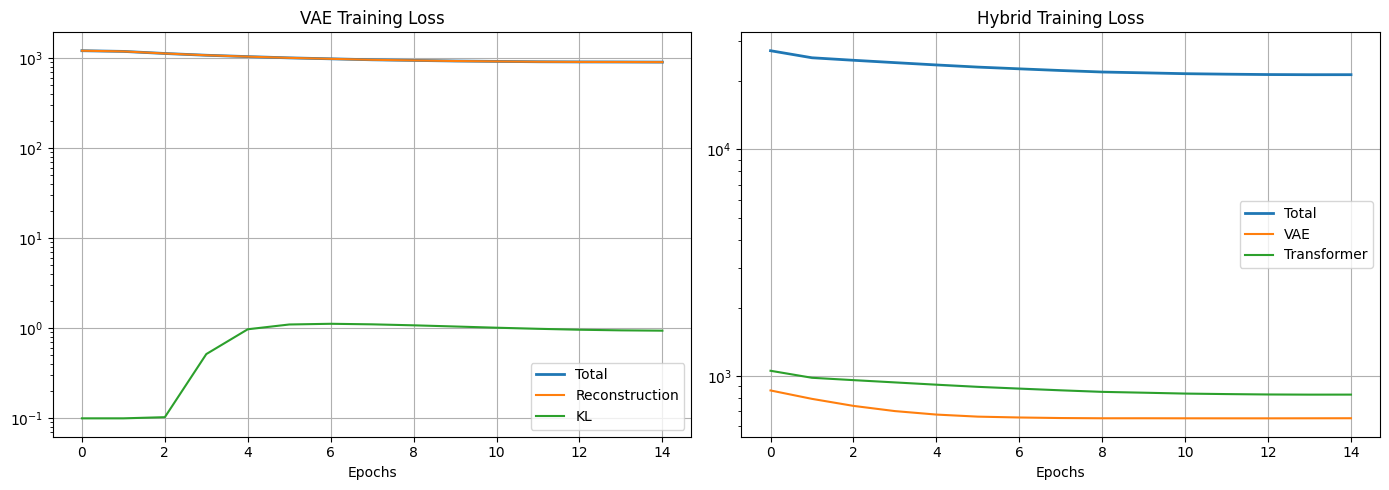

✅ Training curves plotted successfully.
Sample 1 | μ mean=0.4040, μ std=2.7161, z std mean=0.1946
Sample 2 | μ mean=0.4039, μ std=2.7184, z std mean=0.1944
Sample 3 | μ mean=0.4038, μ std=2.7173, z std mean=0.1946


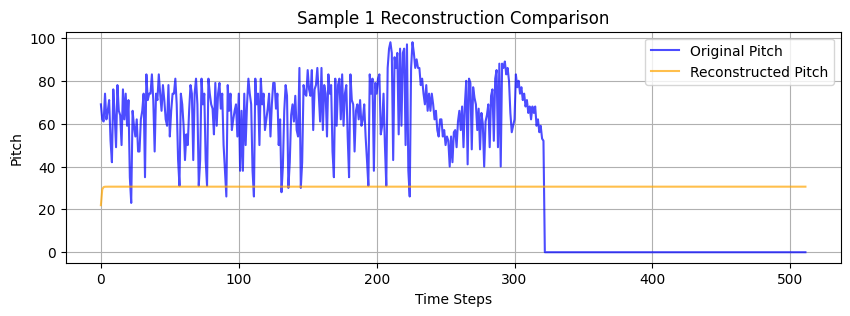

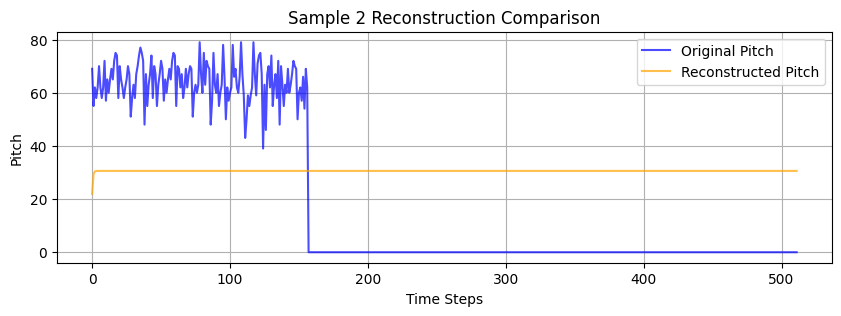

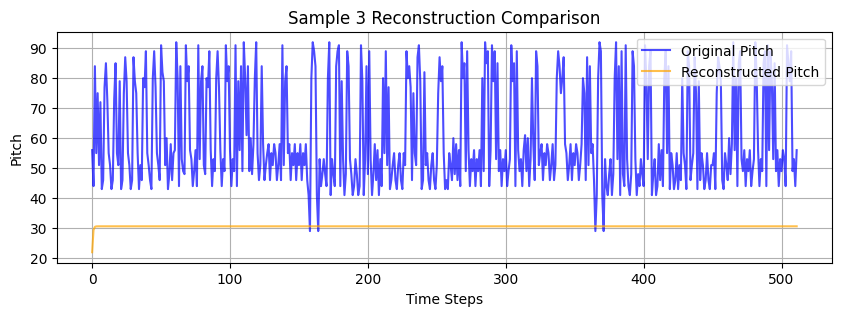

✅ Reconstruction visualization complete.


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# 1. Evaluate model first
metrics = evaluate_model_v2(model, emopia_loader, config)

# 2. Plot training curves (if not already done)
plot_training_curves(vae_logs, hybrid_logs)

# 3. Inspect latent space
inspect_latent_space(model, emopia_loader, num_samples=3)

# 4. Finally, show reconstructions
show_reconstructions(model, emopia_loader, n=3)


In [18]:
# =========================================================
# 🎹 EXPRESSIVE MELODY GENERATION v2 (FOR EXISTING TRAINED MODEL)
# =========================================================
from mido import MidiFile, MidiTrack, Message
import numpy as np, torch, random, os

def generate_expressive_music(model, seq_len=512, latent_dim=128,
                              temperature=1.0, rhythmic_var=0.25, vibrato=0.1,
                              output_path="expressive_melody_v2.mid"):
    """
    Generate a musically expressive 15–30 sec tune with dynamics and variation.
    """
    model.eval()
    with torch.no_grad():
        # 🌈 1. Sample latent vector with temperature scaling
        z = torch.randn((1, latent_dim)).to(device) * temperature

        # 🎵 2. Transformer generates the sequence
        transformer_out = model.transformer(z, seq_len=seq_len)
        generated_seq = transformer_out.squeeze(0).cpu().numpy()

        # 🎚️ 3. Postprocess: Add expressive scaling
        # -- Pitch: dynamic range, small random modulation
        pitches = np.clip((generated_seq[:, 0] * 90 + 30) + np.random.randn(seq_len) * vibrato * 10, 21, 108).astype(int)
        # -- Velocity: exponential shaping for expressive loudness
        velocities = np.clip(((generated_seq[:, 1] * 0.8 + 0.2) ** 2) * 127, 35, 127).astype(int)
        # -- Duration: natural phrasing
        durations = np.clip(np.abs(generated_seq[:, 2]) * 0.4 + 0.1, 0.05, 0.8)
        # -- Time offsets: subtle humanization
        time_offsets = np.clip(np.abs(generated_seq[:, 3]) * 0.3 + rhythmic_var * np.random.rand(seq_len), 0.05, 0.5)

        # 🎼 4. Write to MIDI
        os.makedirs("results", exist_ok=True)
        mid = MidiFile()
        track = MidiTrack()
        mid.tracks.append(track)

        for p, v, d, t in zip(pitches, velocities, durations, time_offsets):
            delta_time = int(t * 480)
            track.append(Message("note_on", note=int(p), velocity=int(v), time=delta_time))
            track.append(Message("note_off", note=int(p), velocity=0, time=int(d * 480)))

        mid.save(os.path.join("results", output_path))
        print(f"✅ Expressive melody saved at: results/{output_path}")

    return generated_seq

In [19]:
generate_expressive_music(
    model,
    seq_len=512,            # 20–25 sec
    latent_dim=config["latent_dim"],
    temperature=1.0,        # melodic balance (try 0.9–1.2)
    rhythmic_var=0.3,       # subtle groove / timing variation
    vibrato=0.15,           # add small pitch expressiveness
    output_path="rich_melody_expressive.mid"
)


✅ Expressive melody saved at: results/rich_melody_expressive.mid


array([[ 6.5257735,  7.1410704, -0.5733204,  3.4457998],
       [ 6.5257735,  7.1410704, -0.5733204,  3.4457998],
       [ 6.5257735,  7.1410704, -0.5733204,  3.4457998],
       ...,
       [ 6.5257735,  7.1410704, -0.5733204,  3.4457998],
       [ 6.5257735,  7.1410704, -0.5733204,  3.4457998],
       [ 6.5257735,  7.1410704, -0.5733204,  3.4457998]],
      shape=(512, 4), dtype=float32)

In [20]:
generate_expressive_music(
    model,
    seq_len=512,            # ~25 sec tune
    latent_dim=config["latent_dim"],
    temperature=1.0,        # balanced
    rhythmic_var=0.25,      # subtle humanization
    vibrato=0.15,           # expressive pitch movement
    output_path="rich_melody_phase2.mid"
)


✅ Expressive melody saved at: results/rich_melody_phase2.mid


array([[ 3.6407766 ,  4.5009375 , -0.46560377,  2.7379353 ],
       [ 3.6407766 ,  4.5009375 , -0.46560377,  2.7379353 ],
       [ 3.6407766 ,  4.5009375 , -0.46560377,  2.7379353 ],
       ...,
       [ 3.6407766 ,  4.5009375 , -0.46560377,  2.7379353 ],
       [ 3.6407766 ,  4.5009375 , -0.46560377,  2.7379353 ],
       [ 3.6407766 ,  4.5009375 , -0.46560377,  2.7379353 ]],
      shape=(512, 4), dtype=float32)

In [21]:
# =========================================================
# 🎹 EXPRESSIVE MUSIC GENERATOR v3 — "TING FIX"
# =========================================================
from mido import MidiFile, MidiTrack, Message
import numpy as np, torch, os

def generate_expressive_music_v3(model, seq_len=512, latent_dim=128,
                                 temperature=1.2, latent_boost=8.0,
                                 rhythmic_var=0.35, vibrato_strength=0.3,
                                 melody_curve=True,
                                 output_path="rich_melody_v3.mid"):
    """
    Generate musically rich melody by scaling latent diversity and melodic contour.
    Fixes monotone 'ting ting' issue by expanding pitch, duration, and dynamics.
    """
    model.eval()
    with torch.no_grad():
        os.makedirs("results", exist_ok=True)

        # 🌈 1. Sample latent vector with boosted std (to explore musical variety)
        z = torch.randn((1, latent_dim)).to(device) * latent_boost

        # 🎵 2. Generate sequence from Transformer
        transformer_out = model.transformer(z, seq_len=seq_len)
        generated_seq = transformer_out.squeeze(0).cpu().numpy()

        # 🔄 3. Normalize & expand outputs for musical expressiveness
        pitches_raw = generated_seq[:, 0]
        velocities_raw = generated_seq[:, 1]
        durations_raw = np.abs(generated_seq[:, 2])
        rhythm_raw = np.abs(generated_seq[:, 3])

        # Optional melodic curve modulation (adds rising/falling motion)
        if melody_curve:
            curve = np.sin(np.linspace(0, 3*np.pi, seq_len))
            pitches_raw = pitches_raw + 0.6 * curve

        # 🎼 4. Postprocess with expressive scaling
        pitches = np.clip((pitches_raw * 50 + 60) + np.random.randn(seq_len) * 2.0, 36, 96).astype(int)
        velocities = np.clip((np.power(velocities_raw + 0.5, 2)) * 127, 40, 120).astype(int)
        durations = np.clip(durations_raw * 0.6 + 0.15, 0.05, 0.8)
        time_offsets = np.clip(rhythm_raw * 0.4 + rhythmic_var * np.random.rand(seq_len), 0.05, 0.6)

        # 🎻 Vibrato-style pitch jitter
        if vibrato_strength > 0:
            vibrato = np.sin(np.linspace(0, np.pi * 6, seq_len)) * vibrato_strength * 2
            pitches = np.clip(pitches + vibrato, 21, 108).astype(int)

        # 🎧 5. Create MIDI file
        mid = MidiFile()
        track = MidiTrack()
        mid.tracks.append(track)

        for p, v, d, t in zip(pitches, velocities, durations, time_offsets):
            delta_time = int(t * 480)
            track.append(Message("note_on", note=int(p), velocity=int(v), time=delta_time))
            track.append(Message("note_off", note=int(p), velocity=0, time=int(d * 480)))

        mid.save(os.path.join("results", output_path))
        print(f"✅ Saved expressive melody: results/{output_path}")

    return pitches, velocities, durations


In [22]:
generate_expressive_music_v3(
    model,
    seq_len=512,           # ~25 sec
    latent_dim=config["latent_dim"],
    temperature=1.2,       # higher = more creative
    latent_boost=8.0,      # key fix — expands variation in z
    rhythmic_var=0.35,
    vibrato_strength=0.25,
    melody_curve=True,
    output_path="final_rich_melody.mid"
)


✅ Saved expressive melody: results/final_rich_melody.mid


(array([96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96,
        96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96,
        96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96,
        96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96,
        96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96,
        96, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95,
        95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95,
        95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95,
        95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95,
        95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95,
        95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96,
        96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96,
        96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96,
        96, 